## Import Statements

In [1]:
import pysptools.util as util
import pandas as pd
import matplotlib.pyplot as plt
from spectral import *
import numpy as np
import pysptools.eea as eea
import spectral.io.envi as envi
import pysptools.eea as eea
import pysptools.abundance_maps as amp
import pysptools.classification as cls
import pysptools.noise as ns
import pysptools.skl as skl
import timeit

KeyboardInterrupt: 

In [2]:
im = plt.imread('methane.png')

![title](methane.png)

## Import data

In [4]:
data_file = r'C:\Users\Dr.RSK\Desktop\Hyperspectral-CNN\AlisoCanyon1\aliso1.hdr'
data, header = util.load_ENVI_file(data_file)

## Dimesnsions before Spatial Removal

In [111]:
data.shape

(5120, 512, 256)

## Setting 2D ground truth map

In [3]:
GT_Dimensions =(5120,512) 

## Set zeroes for Pixels which are not methane in Ground Truth

In [4]:
GT_Array = np.zeros(GT_Dimensions)

In [5]:
GT_Array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Determine Merthane Presence ->Flip to 1

In [9]:

#From GT: 

Y = [4210,4186,4185,4155,4119,4118,4118,4113,4109,4123,4094,4022,4021,4072,4072,4008,4053,4011,4008,3993,3988,3990,3982,3978,3973,3972,3987,3977,3943,3943,3930,3940,3956,3942,3932,3959,3953,3941,3929,3944,3963,3984,3965,3987,3985,3987 ,3987,3938,3980,3972,3989,3940,3942,3975]
X = [27,46,49,31,36,36,40,54,76,149,95,257,258,93,102,187,80,185,185,210,183,210,218,219,233,234,184,202,236,235,236,199,207,234,236,204,205,234,238,113,125,141,123,140,141,155,182,200,205,232,183,200,218,187]

for i in range(0,54):
    x_Dim = X[i]
    y_Dim = Y[i]
    GT_Array[y_Dim][x_Dim]=1

print(GT_Array[4210][27])
print(GT_Array[3975][187])

np.save('GT.npy',GT_Array)

1.0
1.0


## Reflectance values for all pixels across all spectral bands

In [123]:
print(data)

[[[6.30456   6.47104   6.44008   ... 7.1713943 7.226754  7.367842 ]
  [6.366256  6.382112  6.322816  ... 7.3618956 7.1772556 7.524872 ]
  [6.238192  6.3524    6.441248  ... 7.329453  7.579053  7.557485 ]
  ...
  [6.20264   6.237568  6.202608  ... 7.302095  7.242063  7.3557906]
  [6.270048  6.339232  6.1888    ... 7.4885545 7.6951466 7.3430185]
  [6.319312  6.443088  6.259568  ... 7.338101  7.597749  7.507829 ]]

 [[6.173552  6.420736  6.41464   ... 7.2850213 7.2767653 7.346205 ]
  [6.210048  6.366032  6.41104   ... 7.307389  7.3564444 7.325917 ]
  [6.254368  6.328432  6.487248  ... 7.5155478 7.5258193 7.3589396]
  ...
  [6.265744  6.263936  6.270416  ... 7.3813105 7.4708467 7.3175025]
  [6.206     6.366848  6.247792  ... 7.3420134 7.5150695 7.460285 ]
  [6.319312  6.376576  6.268752  ... 7.2920804 7.500849  7.5953126]]

 [[6.173552  6.420736  6.5164    ... 7.3387737 7.4408855 7.096118 ]
  [6.341584  6.422304  6.427088  ... 7.318991  7.2245274 7.1944795]
  [6.327152  6.50416   6.525584 

## Header - Meta Data

In [124]:
print(header)

{'description': 'File imported into ENVI.', 'samples': '512', 'lines': '5120', 'bands': '256', 'header offset': '0', 'file type': 'ENVI Standard', 'data type': '4', 'interleave': 'bip', 'sensor type': 'Unknown', 'byte order': '0', 'wavelength units': 'Micrometers', 'wavelength': ['7.519890', '7.537630', '7.555470', '7.573220', '7.591070', '7.608820', '7.626670', '7.644420', '7.662280', '7.680040', '7.697900', '7.715660', '7.733530', '7.751300', '7.769170', '7.786950', '7.804830', '7.822610', '7.840390', '7.858280', '7.876070', '7.893960', '7.911750', '7.929650', '7.947440', '7.965350', '7.983150', '8.001050', '8.018860', '8.036760', '8.054570', '8.072480', '8.090290', '8.108200', '8.126020', '8.143830', '8.161740', '8.179550', '8.197460', '8.215270', '8.233190', '8.250990', '8.268900', '8.286700', '8.304610', '8.322410', '8.340300', '8.358100', '8.375990', '8.393770', '8.411650', '8.429430', '8.447200', '8.465060', '8.482820', '8.500670', '8.518420', '8.536250', '8.553980', '8.571800',

## NFINDR algorithm to detect endmember spectra of entire image 

In [125]:
def get_endmembers_nfindr(data, header):
    print('Endmembers extraction with NFINDR')
    nfindr = eea.NFINDR()
    U = nfindr.extract(data, 2, maxit=5, normalize=True, ATGP_init=True)
    nfindr.display(header, suffix='Cuprite Endmembers')
    return U

## Define Spatial Cut Functions

In [44]:
del_arr = []
del_arr_Y =[]

In [45]:
def array_cut_Y(X,Y):
    for i in range(X,Y):
        del_arr_Y.append(i)
    return del_arr_Y

In [46]:
def array_cut(X,Y):
    for i in range(X,Y):
        del_arr.append(i)
    return del_arr

## Assign data to holder variable

In [45]:
before_cut = data

## Cut along X dimension 

In [47]:
del_arr = array_cut(0,3912)

In [48]:
del_arr = array_cut(4221,5120)

In [85]:
after_cut = np.delete(before_cut,del_arr,0)

In [49]:
im=np.delete(im,del_arr,0)

In [50]:
im.shape

(309, 512, 3)

In [86]:
after_cut.shape

(309, 512, 256)

## Cut along Y dimension 

In [51]:
del_arr_1 = array_cut_Y(270,512)

In [88]:
after_cut_1 = np.delete(after_cut,del_arr_1,1)

In [52]:
im=np.delete(im,del_arr_Y,1)

In [89]:
after_cut_1.shape

(309, 270, 256)

In [53]:
im.shape

(309, 270, 3)

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1.0]
    G: [0.0, 1.0]
    B: [0.0, 1.0]

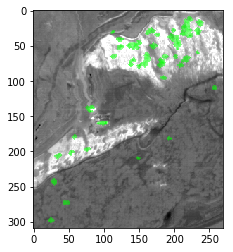

In [54]:
imshow(im)

## Save array after Spatial Removal 

In [8]:
np.save('cutarray.npy',after_cut_1)

In [55]:
np.save('cutGT.npy',im)